<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split


for dirname, _, filenames in os.walk('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/train_transaction.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/train_identity.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/original_data.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/num_sign_col.txt
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/num_sign_col_mice.txt
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/cat_sign_col.txt
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted_old/fitted.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted_old/cat_sign_col.txt
/content/drive/MyDrive/Tesi_magistral

In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

# Preprocessing

## Feature scaling

Implemento il min max scaling delle features. 

Riferimento: https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475

In [3]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv'):
  correlation_data = min_max_scaling(correlation_data)
  correlation_data.to_csv(r'./corr_data.csv')

if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  correlation_data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv')

Riferimento `save_model` e `load_model`: https://stackoverflow.com/questions/56107259/how-to-save-a-trained-model-by-scikit-learn

Riferimento confusion matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


### Dataset merging

Funzione che ritorna la lista delle colonne significative. 

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # serve per ignorare i FutureWarning

Rimpiazzo i missing values in categorical data con unknown. 

Unisco i dataset numerici e categorici nel dataframe data. 

Riferimento fillna: https://jamesrledoux.com/code/imputation

In [5]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  col_to_drop = col_not_sign(categorical_data, cat_sign_col)
  categorical_data = categorical_data.drop(col_to_drop, axis=1)
  categorical_data = categorical_data.fillna('unknown')
  data = pd.merge(correlation_data, categorical_data, left_on='TransactionID', right_on='TransactionID', how='left')
  del correlation_data, categorical_data, numerical_data
  data.to_csv(r'./data.csv')

data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

## One hot encoding

One hot encoding delle features categoriche. Serve per lo smote e easy ensemble. 

Bisogna farlo prima dello split del dataset poichè rischio di perdere delle colonne. 

In [6]:
data = pd.get_dummies(data)

In [7]:
cols = mf.get_col(data)

Seleziono i dati appartenenti ai primi 60 giorni. 

Se ne seleziono di più, l'easy ensemble non va. 

In [8]:
data = mf.select_days(data, 60)

## Time scaling

In [9]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
time = data['TransactionDT'].values.reshape(-1,1)
data['TransactionDT'] = min_max_scaler.fit_transform(time)

## Train validation test split

In [10]:
data.drop(columns=['TransactionID'], inplace=True)

In [11]:
safe = data[data['isFraud'] == 0]
fraud = data[data['isFraud'] == 1]
# fraud.drop(columns=['isFraud'], inplace=True)
del data

Splitto il dataset in train, validation e test set. 

In [12]:
X_train, X_val, y_train, y_val = mf.split(safe, test_size = 0.2)
del safe
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
del y_train, y_val, y_test

In [13]:
fraud_train, fraud_test, y_fraud_train, y_fraud_test = mf.split(fraud, test_size = 0.2)
del fraud, y_fraud_train, y_fraud_test

# Autoencoder

### Training

Codice: https://medium.com/swlh/anomaly-detection-with-autoencoders-2bd23dedbd9e

Altro su keras: https://medium.com/datadriveninvestor/deep-autoencoder-using-keras-b77cd3e8be95

In [14]:
from keras.layers import Input, Dense
from keras.models import Model

input = Input(shape=(X_train.shape[1],))
encoded = Dense(units=128, activation='relu')(input)
# encoded = Dense(units=64, activation='relu')(encoded)
# encoded = Dense(units=32, activation='relu')(encoded)
decoded = Dense(units=32, activation='relu')(encoded)
# decoded = Dense(units=64, activation='relu')(encoded)
decoded = Dense(units=128, activation='relu')(decoded)
decoded = Dense(units=X_train.shape[1], activation='sigmoid')(decoded)

In [15]:
autoencoder=Model(input, decoded)
encoder = Model(input, encoded)
# autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Epoch 1/30
7/7 [==============================] - 8s 943ms/step - loss: 0.2420 - accuracy: 0.0018 - val_loss: 0.2199 - val_accuracy: 1.1686e-04
Epoch 2/30
7/7 [==============================] - 4s 563ms/step - loss: 0.2001 - accuracy: 5.9394e-05 - val_loss: 0.1066 - val_accuracy: 0.0000e+00
Epoch 3/30
7/7 [==============================] - 4s 558ms/step - loss: 0.0750 - accuracy: 5.1487e-05 - val_loss: 0.0103 - val_accuracy: 0.4869
Epoch 4/30
7/7 [==============================] - 4s 555ms/step - loss: 0.0083 - accuracy: 0.8222 - val_loss: 0.0061 - val_accuracy: 0.9999
Epoch 5/30
7/7 [==============================] - 4s 553ms/step - loss: 0.0060 - accuracy: 0.9998 - val_loss: 0.0059 - val_accuracy: 0.9999
Epoch 6/30
7/7 [==============================] - 4s 552ms/step - loss: 0.0059 - accuracy: 0.9998 - val_loss: 0.0058 - val_accuracy: 0.9999
Epoch 7/30
7/7 [==============================] - 4s 566ms/step - loss: 0.0057 - accuracy: 0.9998 - val_loss: 0.0057 - val_accuracy: 0.9999
Epoc

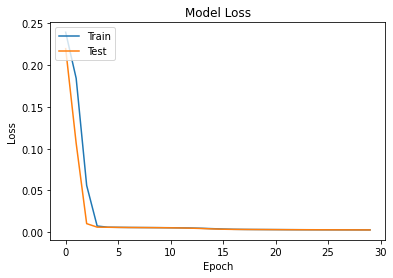

In [16]:
# history = autoencoder.fit(X_train, X_train, epochs=30, batch_size=10000, shuffle=True,
history = autoencoder.fit(X_train, X_train, epochs=30, batch_size=20000, shuffle=True,
                validation_data=(X_val, X_val))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Scelta della soglia

Calcolo la ricostruzione dei validation set fatta dall'autoencoder. 

Calcolo il MSE per ogni feature vector e costruisco due dataset che poi unirò. 

In [17]:
mse_df = mf.make_df(X_val, fraud_train, autoencoder)

hline: https://stackoverflow.com/questions/60309406/draw-horizontal-line-on-facetplot-seaborn-relplot

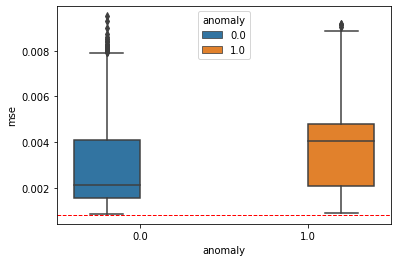

In [18]:
plot = sns.boxplot(x='anomaly', y='mse', hue='anomaly', data = mse_df)
soglia = 0.0008
plot.axhline(soglia, ls='--', linewidth=1, color='red')

plt.show()

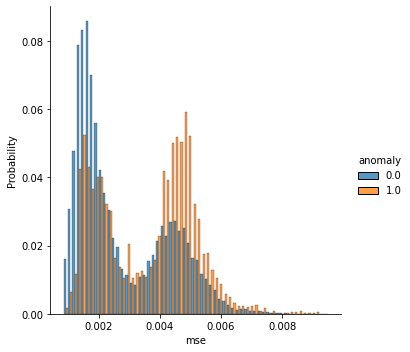

In [19]:
sns.displot(mse_df, x="mse", hue="anomaly", stat="probability", common_norm=False, multiple = 'dodge')

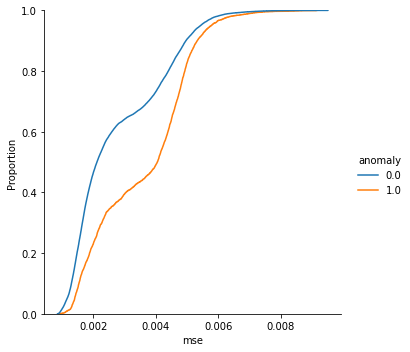

In [20]:
sns.displot(mse_df, x="mse", hue="anomaly", kind="ecdf")

Pandas quantile: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.quantile.html

In [21]:
print(mse_df[mse_df['anomaly'] == 0].quantile(0.5)[0].round(5))
print(mse_df[mse_df['anomaly'] == 1].quantile(0.3)[0].round(5))

0.00211
0.00227


In [22]:
soglia = mse_df[mse_df['anomaly'] == 0].quantile(0.5)[0].round(5)

### Test modello

In [23]:
mf.performance_autoencoder(X_test, fraud_test, autoencoder, soglia)

[[21241 21546]
 [ 1032   342]]
